In [187]:
# From data import S.npy
import numpy as np
import matplotlib.pyplot as plt

S1 = np.load(r'src\data\S.npy')
S2 = np.load(r'src\data\S1.npy')
S3 = S1 + np.random.rand(*S1.shape) * 0.1
S4 = S1 + np.random.rand(*S1.shape) * 0.2
S5 = S2 + np.random.rand(*S2.shape) * 0.1

# K = 1 (one archetype)
S_list1 = [S1, S2, S3, S4, S5]

# K = 2 (two archetypes)
S_list2 = [S1, S2, S3, S4, S5]

# List of lists of S matrices (list for one lab)
S_lists = [S_list1, S_list2]


# Artificial lab lists
lab1_S_list = [S_list1, S_list2] # Here S_list1 is for K = 1, and S_list2 is for K = 2. 
# lab2_S_list = [S1, S2, S3, S4, S5]
lab_S_lists = [lab1_S_list]

In [186]:
S1.shape

(5, 90000)

In [184]:
import numpy as np
# Define a function to calculate NMI
def calculate_MI(S1, S2):
    """
    This function calculates the Mutual Information (MI) between two matrices with continuous data.
    """
    
    # Calculate p(d, d') as the dot product between S1 and S2 transpose (normalized)
    prob = S1@S2.T

    # Normalize joint distribution to ensure it sums to 1
    prob_XY = prob/np.sum(prob)

    # Calculate marginal distributions
    prob_X_Y = np.outer(np.sum(prob_XY, axis=1), np.sum(prob_XY, axis=0))
    
    # Makes sure that the probability larger than 0
    ind = np.where(prob_XY > 0)

    # Calculate mutual information
    MI = np.sum(prob_XY[ind] * np.log(prob_XY[ind] / prob_X_Y[ind]))

    return MI

def calculate_NMI(S1, S2):
    """
    Calculate the Normalized Mutual Information (NMI) between two matrices with continuous data.
    """
    # Calculate NMI
    NMI = 2 * calculate_MI(S1,S2) / (calculate_MI(S1, S1) + calculate_MI(S2,S2))
    
    return NMI


In [179]:

def calculate_NMI_list(S_list):
    """
    Calculate the NMI between all pairs of S matrices in a list. The last matrix is compared with the first one.

    Returns a list of NMI values for each pair. The list has dimension len(S_list).
    """
    return [calculate_NMI(S_list[i], S_list[(i + 1) % len(S_list)]) for i in range(len(S_list))]

def nmi_boxplot(S_lists):
    """
    Plots a single figure with boxplots for different numbers of components.
    
    :param S_lists: List of lists of S matrices. Each list corresponds to a different number of components.
    
    """
    # Initialize an empty list to store the NMI values
    nmi_values = []
    
    # Loop over each pair of S matrices
    # The last S matrix is compared with the first one
    for S_list in S_lists:
    # Calculate NMI for consecutive pairs and wrap around from the last to the first
        nmi_pairs = calculate_NMI_list(S_list)
        nmi_values.append(nmi_pairs)
    # Plot the NMI values as a boxplot
    plt.boxplot(nmi_values)
    plt.xlabel('K components')
    plt.ylabel('NMI')
    plt.title('NMI between S matrices for different components')
    plt.show()


def nmi_lineplot(lab_S_lists):
    """
    Plots a single figure with boxplots and interpolation lines for different labs.
    Each lab's line shows the trend across different numbers of components.
    Boxplots represent the distribution of NMI values for each component configuration.

    :param labs_data: List of lists of lists. 
                      Each top-level list corresponds to a different lab.
                      Each second-level list corresponds to a specific number of components.
                      Each third-level list contains S matrices for different runs.
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 5), constrained_layout=True)
    colors = plt.cm.viridis(np.linspace(0, 1, len(lab_S_lists)))  # Color map for different labs

    for idx, lab_data in enumerate(lab_S_lists):
        nmi_values = [calculate_NMI_list(S_list) for S_list in lab_data]
        nmi_values = np.array(nmi_values).T  # Transpose for boxplot compatibility
        
        # Prepare x positions for boxplots to avoid overlap
        positions = [i + 0.1 * (idx - (len(lab_S_lists) - 1) / 2) for i in range(1, len(lab_data) + 1)]

        # Boxplot for each lab
        ax.boxplot(nmi_values, positions=positions, widths=0.1, patch_artist=True, boxprops=dict(facecolor=colors[idx]))

        # Mean NMI for line plotting
        nmi_means = np.mean(nmi_values, axis=0)
        ax.plot(range(1, len(lab_data) + 1), nmi_means, 'o-', label=f'Lab {idx + 1}', color=colors[idx])

    ax.set_xlabel('K components')
    ax.set_ylabel('NMI')
    ax.set_title('NMI between S matrices for different components')
    ax.legend(title='Labs')
    num_components = len(lab_S_lists[0])
    central_positions = [i + 1 for i in range(num_components)]  # No offset calculation needed for simply labeling
    ax.set_xticks(central_positions)
    ax.set_xticklabels(range(1, num_components + 1))
    plt.show()
    
    

def permute_and_calculate_NMI(S_list, num_permutations=50):

    """
    This function takes a list of lists of S matrices and calculates the NMI between each pair of matrices with permutations.

    :param S_list: List of lists of S matrices. Each list corresponds to a different number of components.
    :param num_permutations: Number of permutations to calculate NMI scores.

    :return: List of lists of NMI scores for each number of components.
    
    """
    # NMI score for every component
    all_component_scores = []  # List of lists to store NMI scores for each component count

    for S_list in S_lists:
        component_scores = []  # Scores for this particular component count
        num_matrices = len(S_list)

        for i in range(num_matrices):
            S1 = np.array(S_list[i])
            S2 = np.array(S_list[(i + 1) % num_matrices])  # Wrap-around for the last element
            for _ in range(num_permutations):
                permuted_S2 = S2[:, np.random.permutation(S2.shape[1])]
                nmi = calculate_NMI(S1, permuted_S2)
                component_scores.append(nmi)

        all_component_scores.append(component_scores)

    return all_component_scores


def plot_histogram(scores, bins=30, title="Histogram of NMI Scores"):
    """
    This function plots a histogram of NMI scores for permuted matrices.
    
    """
    plt.figure(figsize=(10, 6))
    plt.hist(scores, bins=bins, color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel('NMI Score')
    plt.ylabel('Frequency')
    plt.show()


def plot_comparison_nmi(S_lists):
    fig, ax = plt.subplots(figsize=(12, 6))
    all_original_scores = []
    all_permuted_scores = []

    # Compute and collect NMI scores for each set of components
    for S_list in S_lists:
        original_scores = [calculate_NMI(np.array(S_list[i]), np.array(S_list[(i + 1) % len(S_list)])) for i in range(len(S_list))]
        all_original_scores.append(original_scores)
        
        permuted_scores = permute_and_calculate_NMI(S_list)
        permuted_scores_flat = [item for sublist in permuted_scores for item in sublist]
        all_permuted_scores.append(permuted_scores_flat)

    n_components = len(S_lists)
    positions = np.arange(1, n_components + 1)

    # Plotting original scores directly over the ticks
    ax.boxplot(all_original_scores, positions=positions, widths=0.3, patch_artist=True, 
               boxprops=dict(facecolor='lightblue'), labels=['Original']*n_components)

    # Plotting permuted scores directly over the ticks, slightly offset
    ax.boxplot(all_permuted_scores, positions=positions, widths=0.3, patch_artist=True, 
               boxprops=dict(facecolor='lightgreen'), labels=['Permuted']*n_components)

    ax.set_title('Comparison of NMI Scores: Original vs Permuted')
    ax.set_xlabel('Number of Components')
    ax.set_ylabel('NMI Scores')
    ax.set_xticks(positions)
    ax.set_xticklabels([i for i in positions])
    plt.legend(['Original', 'Permuted'])
    plt.grid(True)
    plt.show()

## Boxplot of NMI for different numbers of components, for one lab

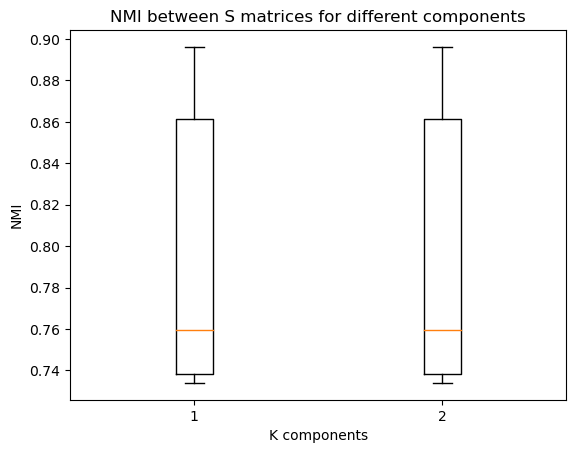

In [181]:
nmi_boxplot(S_lists)

## Lineplot of NMI for different numbers of components, for different labs 

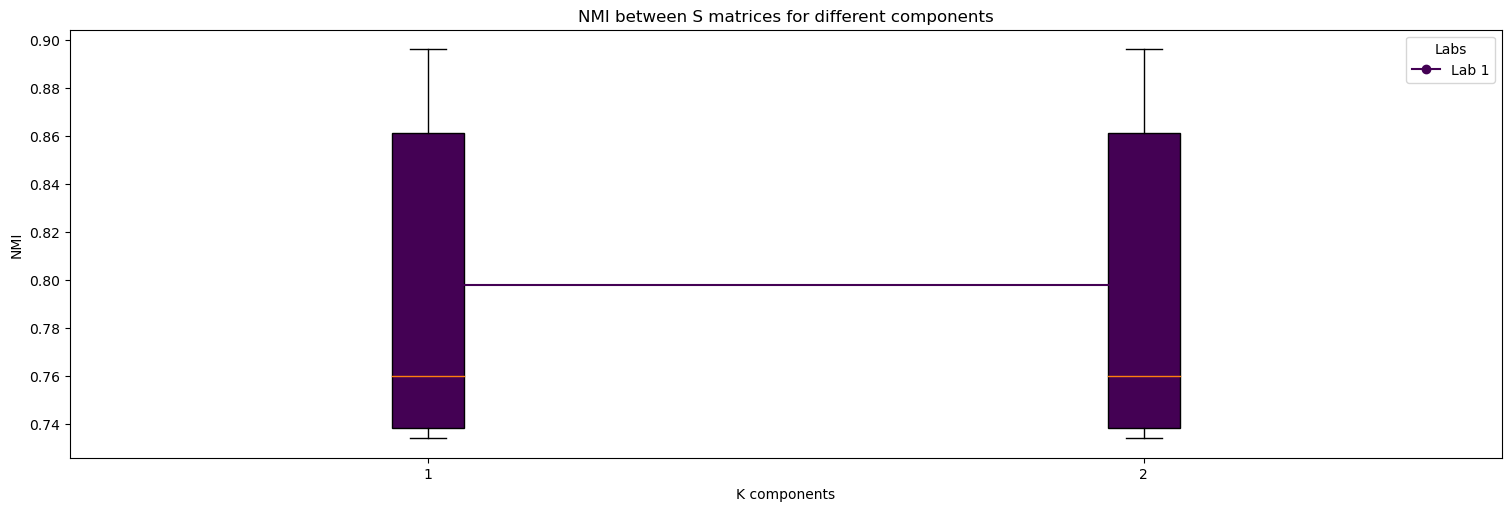

In [182]:
nmi_lineplot(lab_S_lists)

## Histogram of permutations of S-matrices for one number of components

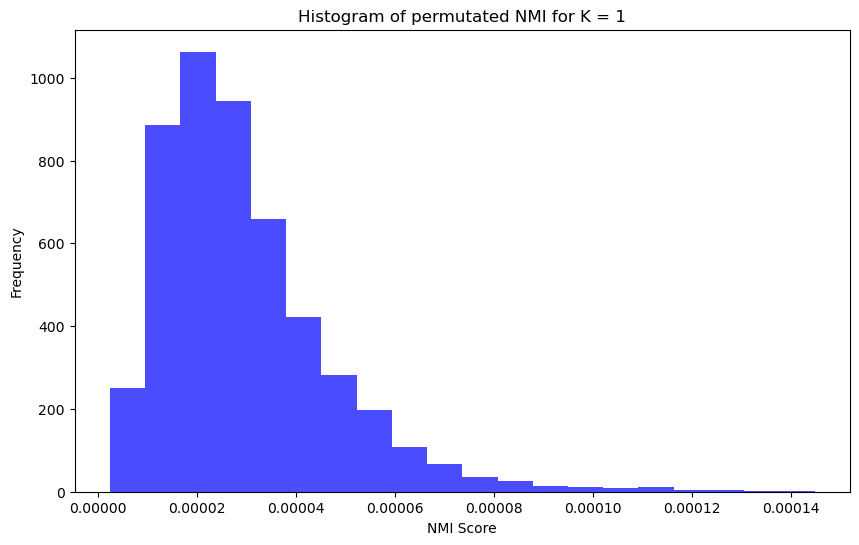

In [160]:
plot_histogram(permute_and_calculate_NMI(S_lists, num_permutations=1000)[0], bins=20, title="Histogram of permutated NMI for K = 1")

## Plot of NMI scores for permutated S-matrices and the original S-matrices

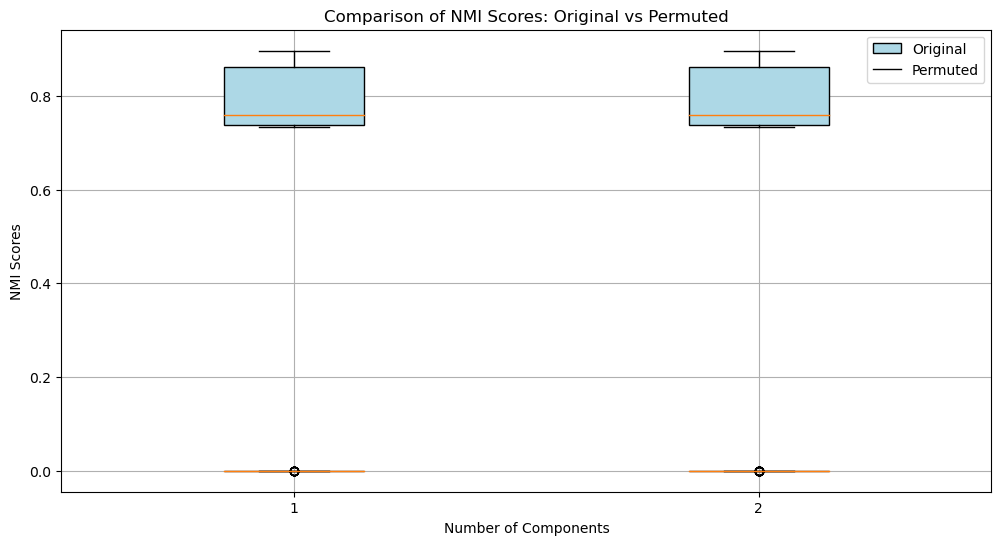

In [180]:
plot_comparison_nmi(S_lists)